In [1]:
import hist
import matplotlib.pyplot as plt
import mplhep as hep
import numpy as np
import os
import sys
import torch
import torch.backends.cudnn as cudnn
import torch.cuda as tcuda
import torch.nn as nn
import yaml

from torch.nn.functional import softmax
from utils import get_data_loader

from sklearn.metrics import (
    auc,
    accuracy_score,
    average_precision_score,
    precision_recall_curve,
    roc_curve
)
from scipy.stats import pearsonr

from suepvision.smodels import (
    LeNet5,
    get_resnet18,
    get_resnet50
)

hep.style.use("CMS")

In [2]:
config = yaml.safe_load(open("configs/resnet18-boosted-classifier.yml"))
dataset = config['dataset']
evaluation_pref = config['evaluation_pref']

In [3]:
MODEL_NAME_1 = 'ResNet18-Boosted-Single-Track'

model1 = eval(config['architecture'])()
model1.load_state_dict(torch.load("models/{}.pth".format(MODEL_NAME_1)))
model1 = model1.to(0)

MODEL_NAME_2 = 'ResNet18-Boosted-Single-Sphericity'

model2 = eval(config['architecture'])()
model2.load_state_dict(torch.load("models/{}.pth".format(MODEL_NAME_2)))
model2 = model2.to(0)

In [4]:
test_loader = get_data_loader(
    dataset['test'][0],
    evaluation_pref['batch_size'],
    evaluation_pref['workers'],
    dataset['in_dim'],
    0,
    boosted=dataset['boosted'],
    shuffle=False
)

In [5]:
results_track = torch.tensor([])
results_sphericity = torch.tensor([])
all_tracks = torch.tensor([])
all_sphericity = torch.tensor([])

model1.eval()
model2.eval()
with torch.no_grad():
    for images, targets, tracks, sphericity in test_loader:
        targets = tcuda.LongTensor(targets, device=0)
        tracks = tcuda.FloatTensor(tracks, device=0)
        sphericity = tcuda.FloatTensor(sphericity, device=0)
        
        all_tracks = torch.cat((all_tracks, tracks.cpu()), 0)
        all_sphericity = torch.cat((all_sphericity, sphericity.cpu()), 0)
        
        outputs1 = model1(images)
        outputs2 = model2(images)
        
        batch_results1 = torch.cat((targets.reshape(-1, 1), outputs1), 1)
        batch_results2 = torch.cat((targets.reshape(-1, 1), outputs2), 1)
        
        results_track = torch.cat((results_track, batch_results1.cpu()), 0)
        results_sphericity = torch.cat((results_sphericity, batch_results2.cpu()), 0)

In [29]:
CV = 10

y_true1 = results_track[:, 0]
y_true2 = results_sphericity[:, 0]
y_pred1 = softmax(results_track[:, 1:], 1)
y_pred2 = softmax(results_sphericity[:, 1:], 1)
y_pred1 = y_pred1[:, 1].detach().cpu().numpy()
y_pred2 = y_pred2[:, 1].detach().cpu().numpy()

samples_per_cv = len(y_true1) // CV

acc1, acc2, corr1, corr2 = [], [], [], []
for i in range(CV):
    y_true1_cv = y_true1[i*samples_per_cv:(i+1)*samples_per_cv]
    y_true2_cv = y_true2[i*samples_per_cv:(i+1)*samples_per_cv]
    y_pred1_cv = y_pred1[i*samples_per_cv:(i+1)*samples_per_cv]
    y_pred2_cv = y_pred2[i*samples_per_cv:(i+1)*samples_per_cv]
    
    tracks_cv = all_tracks[i*samples_per_cv:(i+1)*samples_per_cv]
    sphericity_cv = all_sphericity[i*samples_per_cv:(i+1)*samples_per_cv]

    acc1.append(accuracy_score(y_true1_cv, y_pred1_cv > .5))
    corr1.append(pearsonr(y_pred1_cv[y_true1_cv == 0], tracks_cv.detach().cpu().numpy()[y_true1_cv == 0])[0])
    
    acc2.append(accuracy_score(y_true2_cv, y_pred2_cv > .5))
    corr2.append(pearsonr(y_pred2_cv[y_true2_cv == 0], sphericity_cv.detach().cpu().numpy()[y_true2_cv == 0])[0])

print(u'Accuracy Tracks: {0:.3f} \u00B1 {1:.3f}'.format(np.mean(acc1), np.std(acc1)))
print(u'Correlation Tracks: {0:.3f} \u00B1 {1:.3f}'.format(np.mean(corr1), np.std(corr1)))
print(u'Accuracy Sphericity: {0:.3f} \u00B1 {1:.3f}'.format(np.mean(acc2), np.std(acc2)))
print(u'Correlation Sphericity: {0:.3f} \u00B1 {1:.3f}'.format(np.mean(corr2), np.std(corr2)))

Accuracy Tracks: 0.958 ± 0.002
Correlation Tracks: 0.104 ± 0.009
Accuracy Sphericity: 0.959 ± 0.002
Correlation Sphericity: -0.010 ± 0.011


In [37]:
suep_cl1 = all_tracks[y_true1 == 1]
suep_cl2 = y_pred1[y_true1 == 1]

qcd_cl1 = all_tracks[y_true1 == 0]
qcd_cl2 = y_pred1[y_true1 == 0]

In [40]:
qcd_cl1.min()

tensor(2.)

In [41]:
hist_abcd = (
     hist.new
    .Regular(50, 0, 200, name="ntracks", label="# Tracks")
    .Regular(50, 0, 1, name="classifier_output", label="Classifier Output")
    .Weight()
)

hist_abcd.fill(qcd_cl1, qcd_cl2)

Hist(
  Regular(50, 0, 200, name='ntracks', label='# Tracks'),
  Regular(50, 0, 1, name='classifier_output', label='Classifier Output'),
  storage=Weight()) # Sum: WeightedSum(value=49999, variance=49999) (WeightedSum(value=50000, variance=50000) with flow)

In [42]:
hist_abcd_suep = (
     hist.new
    .Regular(50, 0, 200, name="ntracks", label="# Tracks")
    .Regular(50, 0, 1, name="classifier_output", label="Classifier Output")
    .Weight()
)

hist_abcd_suep.fill(suep_cl1, suep_cl2)

Hist(
  Regular(50, 0, 200, name='ntracks', label='# Tracks'),
  Regular(50, 0, 1, name='classifier_output', label='Classifier Output'),
  storage=Weight()) # Sum: WeightedSum(value=49296, variance=49296) (WeightedSum(value=50000, variance=50000) with flow)

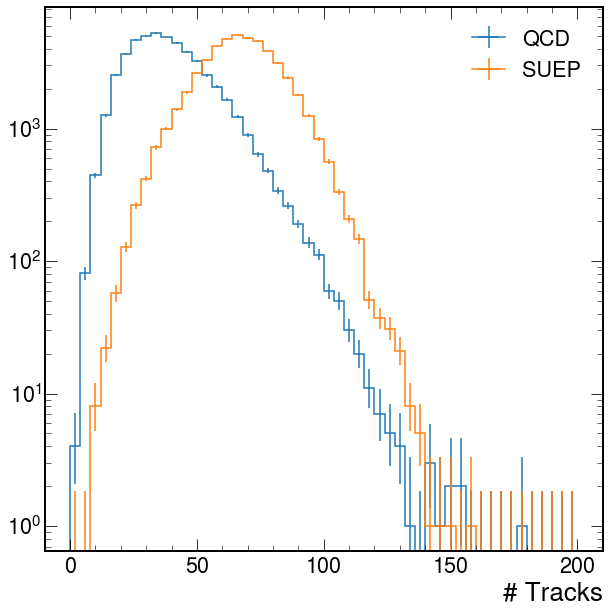

In [43]:
_ = hep.histplot(hist_abcd.project(0), label="QCD")
_ = hep.histplot(hist_abcd_suep.project(0), label="SUEP")
_ = plt.yscale('log')
_ = plt.legend()

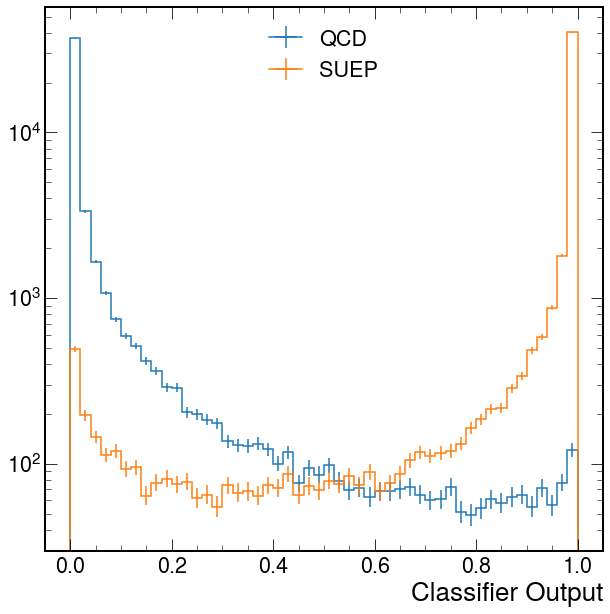

In [44]:
_ = hep.histplot(hist_abcd.project(1), label="QCD")
_ = hep.histplot(hist_abcd_suep.project(1), label="SUEP")
_ = plt.yscale('log')
_ = plt.legend()

In [57]:
ntracks_cut = 60j
cl_cut = 0.5j

A = hist_abcd[:ntracks_cut, :cl_cut]
B = hist_abcd[ntracks_cut:, :cl_cut]
C = hist_abcd[:ntracks_cut, cl_cut:]
D = hist_abcd[ntracks_cut:, cl_cut:]
D_exp = C.copy() * B.sum().value / A.sum().value

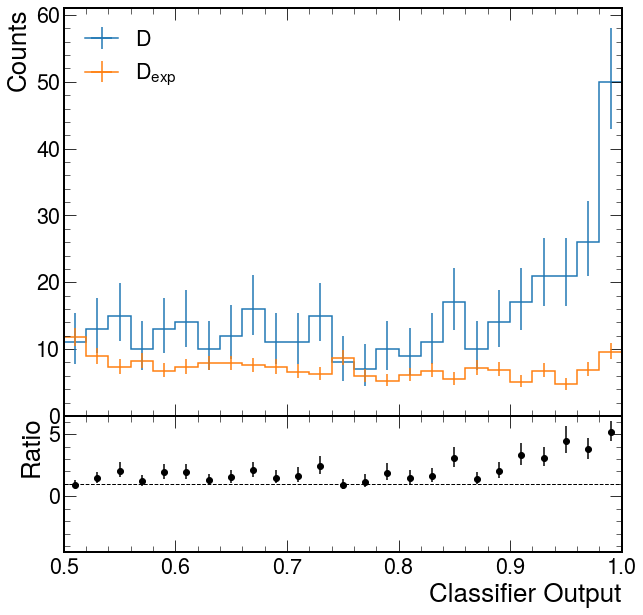

In [58]:
# https://github.com/scikit-hep/hist/blob/main/src/hist/plot.py

D_cl = D[ntracks_cut::sum,cl_cut:]
D_exp_cl = D_exp[:ntracks_cut:sum,cl_cut:]
_ = D_cl.plot_ratio(D_exp_cl,
                    rp_num_label='D',
                    rp_denom_label='$D_{exp}$')